# Summary

Milestone 1 of reinforcement learning project.

## TODO
1. Solving statistics. (Get something reasonable)
2. Check as matrices get larger
3. Get avgs 
    1. Hilbert + perturb (GMRES)
        1. [20, 100, 500, 1000] 
        2. [Jacobi, ILU, AMG]
    1. Helmholtz + perturb 
        1. [20, 100, 500, 1000] 
        2. [Jacobi, ILU, AMG]

## Paper TODO
1. Define the Helmholtz equations. How they are discretized.
2. Define the perturbations.
3. Define DDPG.
4. State why RL, and why this algorithm.
5. State reward function.
6. Stat we are using a GNN, and why (ask why this is import ant for these types of systems).
7. Show the current solving statistics for Helmholtz.
8. Discuss expected results, outcomes.


Two options: GMRES (SS = A) || FMGRES adaptive (SS = r_0)

# Imports/Setup

In [2]:
from scipy.linalg import hilbert
import scipy.linalg as la
import scipy.sparse.linalg as spla
import numpy as np
import scipy 
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pyamg
import seaborn as sns

# Hilbert Matrices

Get the hilbert matrices and inspect them.

These matrices are SPD and become significantly ill conditioned as their size increases.

In [3]:
hilbert(3)

array([[1.        , 0.5       , 0.33333333],
       [0.5       , 0.33333333, 0.25      ],
       [0.33333333, 0.25      , 0.2       ]])

In [4]:
hilbert(10)

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667,
        0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714,
        0.125     , 0.11111111, 0.1       , 0.09090909, 0.08333333],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ,
        0.11111111, 0.1       , 0.09090909, 0.08333333, 0.07692308],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111,
        0.1       , 0.09090909, 0.08333333, 0.07692308, 0.07142857],
       [0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
        0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667],
       [0.14285714, 0.125     , 0.11111111, 0.1       , 0.09090909,
        0.08333333, 0.07692308, 0.07142857, 0.06666667, 0.0625    ],
       [0.125     , 0.11111111, 0.1      

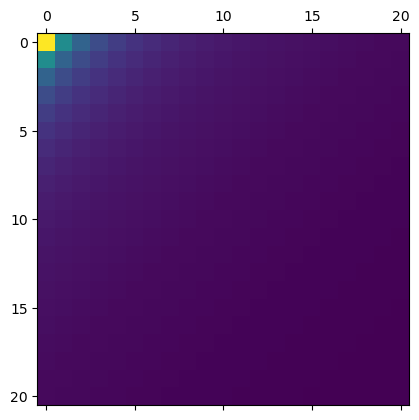

In [5]:
_ = plt.matshow(hilbert(21))

In [6]:
def summary(size):
    H = hilbert(size)
    print(f'SIZE: {size}, MIN {H.min():.5f}, MEAN {H.mean():.5f}, MAX {H.max():.5f}')

In [7]:
summary(10)

SIZE: 10, MIN 0.05263, MEAN 0.13375, MAX 1.00000


In [8]:
summary(100)

SIZE: 100, MIN 0.00503, MEAN 0.01381, MAX 1.00000


In [9]:
summary(1000)

SIZE: 1000, MIN 0.00050, MEAN 0.00139, MAX 1.00000


## Random Pertubations

Get different distributions of pertubations.

### Normal

Normally distrubted pertubation.

In [10]:
def normal_perturbation(matrix, scale=1e-3):
    perturbation = scale * np.random.randn(*matrix.shape) 
    return matrix + perturbation

In [11]:
normal_perturbation(hilbert(4), scale=1e-7)

array([[0.99999998, 0.50000015, 0.33333352, 0.25000002],
       [0.50000004, 0.33333315, 0.25000002, 0.20000014],
       [0.33333326, 0.24999991, 0.19999988, 0.16666656],
       [0.24999989, 0.19999998, 0.16666683, 0.14285718]])

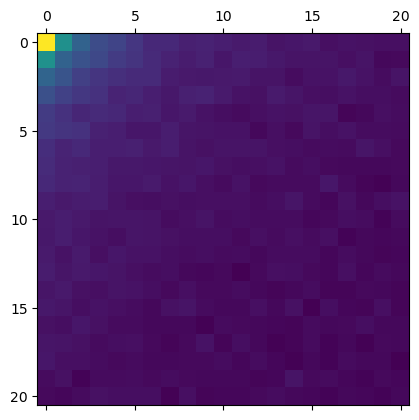

In [12]:
_ = plt.matshow(normal_perturbation(hilbert(21), scale=1e-2))

### Uniform

Uniformly distrubted pertubation.

In [13]:
def uniform_perturbation(matrix, low=-1e-3, high=1e-3):
    perturbation = np.random.uniform(low, high, size=matrix.shape)
    return matrix + perturbation

In [14]:
uniform_perturbation(hilbert(4), low=-1e-1, high=1e-1)

array([[1.06870628, 0.53099222, 0.39676445, 0.2687431 ],
       [0.58572136, 0.23465732, 0.24876376, 0.12503111],
       [0.38927296, 0.25424803, 0.27045374, 0.11125075],
       [0.25542768, 0.12466418, 0.172303  , 0.23494546]])

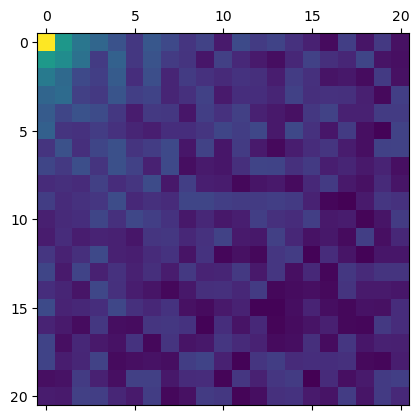

In [15]:
_ = plt.matshow(uniform_perturbation(hilbert(21), low=-1e-1, high=1e-1))

## b Vectors

Randomly initialized b vectors.

### Normal

Normally distrubted vector.

In [16]:
def normal_b_vector(size, scale=1e-3):
    return scale * np.random.randn(size)

In [17]:
normal_b_vector(hilbert(3).shape[0], scale=1)

array([ 1.77329022, -0.60909508, -0.59684336])

### Uniform

Uniformly distrubted vector.

In [18]:
def uniform_b_vector(size, low=-1e-3, high=1e-3):
    return np.random.uniform(low, high, size=size)

In [19]:
uniform_b_vector(hilbert(3).shape[0], low=-2, high=2)

array([0.62597387, 1.23588957, 0.73560506])

## Solvers

Different types of commonly used solvers.

In [20]:
class Callback:
    def __init__(self):
        self.cb = 0

    def log(self, r):
        self.cb += 1

### Conjugate Gradient (CG)

Solver good for SPD.

In [21]:
A = normal_perturbation(hilbert(3), scale=1e-1)
b = normal_b_vector(A.shape[0], scale=1)
cb = Callback()

x, exit_code = spla.cg(A, b, callback=cb.log)

An exit code > 0 indicates no convergence.

In [22]:
exit_code, cb.cb

(30, 30)

### Generalized Minimal RESidual (GMRES)

Solver good for non-symmetric, indefinite.

In [23]:
A = normal_perturbation(hilbert(20), scale=1e-1)
b = normal_b_vector(A.shape[0], scale=1)
cb = Callback()

x, exit_code = spla.gmres(A, b, callback_type='legacy', callback=cb.log, maxiter=10000, restart=10)

In [24]:
exit_code, cb.cb

(10000, 10000)

## Preconditioning

Common preconditioning techniques.

### Jacobi

M = diag(A) preconditioner.

In [25]:
A = normal_perturbation(hilbert(20), scale=1e-1)
b = normal_b_vector(A.shape[0], scale=1)
M = np.eye(A.shape[0]) * (1 / np.diag(A))
cb = Callback()

x, exit_code = spla.gmres(A, b, M=M, callback_type='legacy', callback=cb.log, maxiter=10000, restart=10, rtol=1e-12)

In [26]:
exit_code, cb.cb

(10000, 10000)

(368.03238736696835, 103.34698659102574)

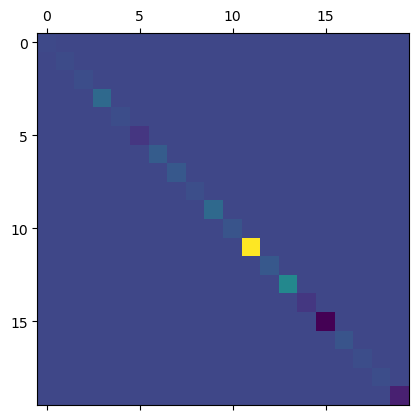

In [27]:
plt.matshow(M)
np.linalg.cond(M @ A), np.linalg.cond(A)

### Incomplete LU (ILU)

Approximates the LU decomposition.

In [28]:
A = normal_perturbation(hilbert(100), scale=1e-2)
b = normal_b_vector(A.shape[0], scale=1)

ilu = spla.spilu(A)
Mx = lambda x: ilu.solve(x)
M = spla.LinearOperator(A.shape, Mx)

cb = Callback()

x, exit_code = spla.gmres(A, b, M=M, callback_type='legacy', callback=cb.log, maxiter=10000, restart=20, rtol=1e-12)

/tmp/ipykernel_2947540/1902163583.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A)


Can effiecently precondition for perturbed hilbert matrices.

In [29]:
exit_code, cb.cb

(0, 1)

(1.0000000000032683, 21289.70067486121)

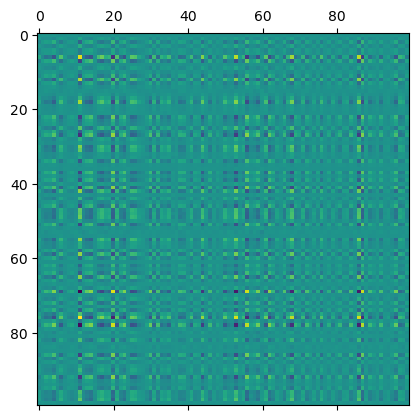

In [30]:
plt.matshow(M.dot(np.eye(100)))
np.linalg.cond(M @ A), np.linalg.cond(A)

(1.0000000000032683, 21289.70067486121)

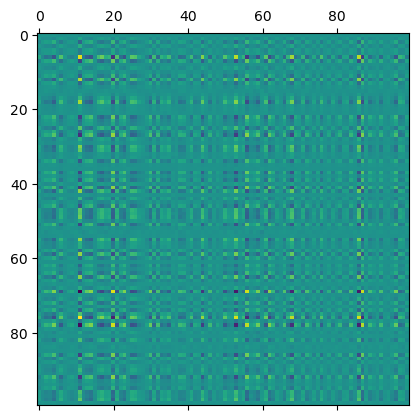

In [31]:
plt.matshow(M.dot(np.eye(100)))
np.linalg.cond(M @ A), np.linalg.cond(A)

In [32]:
A = normal_perturbation(hilbert(1000), scale=1e-2)
b = normal_b_vector(A.shape[0], scale=1)

ilu = spla.spilu(A)
Mx = lambda x: ilu.solve(x)
M = spla.LinearOperator(A.shape, Mx)

cb = Callback()

x, exit_code = spla.gmres(M @ A, M @ b, callback_type='legacy', callback=cb.log, maxiter=10000, restart=20, rtol=1e-12)

/tmp/ipykernel_2947540/53373813.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A)


*We also get equal speedup using this approach.*

In [33]:
exit_code, cb.cb

(0, 3)

## Solver Statistics

Understand more about the significant of A and b.

# Helmholtz Matrix

Discretized waveforms. 

*Anythong below 500 suffers from non-singularity using this discretization.*

In [34]:
def test_singularity(mat):
    det_mat = np.linalg.det(mat)

    if np.isclose(det_mat, 0):
        print("Matrix is singular.")
        return False
    else:
        print("Matrix is non-singular.")
        
    rank_mat = np.linalg.matrix_rank(mat)
    if rank_mat < A.shape[0]:
        print("Matrix is singular.")
        return False
    else:
        print("Matrix is non-singular.")
        
    return True

In [35]:
def test_inconsistent(A, b):
    augmented_matrix = np.column_stack((A, b))

    # Perform LU decomposition and check for inconsistent row
    P, L, U = scipy.linalg.lu(augmented_matrix)

    # Check last row of U for inconsistency (e.g., [0 0 0 | c])
    if np.allclose(U[-1, :-1], 0) and not np.isclose(U[-1, -1], 0):
        print("System is inconsistent.")
    else:
        print("System may be consistent.")
        
    rank_A = np.linalg.matrix_rank(A)
    rank_augmented = np.linalg.matrix_rank(augmented_matrix)

    if rank_A != rank_augmented:
        print("System is inconsistent.")
    else:
        print("System is consistent or has infinitely many solutions.")

In [36]:
def get_helmholtz(n, wavesize):
    L = 1.0 
    k = wavesize 
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    return (sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)).toarray()

In [37]:
get_helmholtz(5, 100)

array([[9968.,   16.,    0.,    0.,    0.],
       [  16., 9968.,   16.,    0.,    0.],
       [   0.,   16., 9968.,   16.,    0.],
       [   0.,    0.,   16., 9968.,   16.],
       [   0.,    0.,    0.,   16., 9968.]])

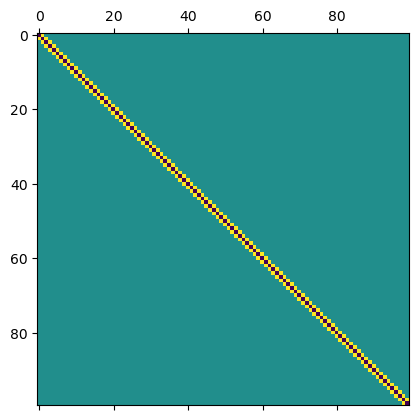

In [38]:
_ = plt.matshow(get_helmholtz(100, 100))

In [39]:
def summary(size, wave):
    H = get_helmholtz(size, wave)
    print(f'SIZE: {size}, MIN {H.min():.5f}, MEAN {H.mean():.5f}, MAX {H.max():.5f}')

In [40]:
summary(5, 100)

SIZE: 5, MIN 0.00000, MEAN 1998.72000, MAX 9968.00000


In [41]:
summary(5, 10)

SIZE: 5, MIN 0.00000, MEAN 18.72000, MAX 68.00000


In [42]:
summary(1000, 100)

SIZE: 1000, MIN -1986002.00000, MEAN 8.00400, MAX 998001.00000


In [43]:
summary(1000, 1)

SIZE: 1000, MIN -1996001.00000, MEAN -1.99500, MAX 998001.00000


## Randomness & Perturbations

Apply randomness to the initialization and perturbations to matrices.

In [44]:
def generate_random_helmholtz(n, density=0.001):
    L = 1.0
    k = np.random.uniform(10, 200)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    perturb.setdiag(0)
    
    for i in [-1, 1]:  
        diag_indices = np.arange(max(0, -i), min(n, n - i)) 
        perturb[diag_indices, diag_indices + i] = 0
        
    return helmholtz + perturb

In [45]:
def get_sparsity(mat):
    return (mat != 0).sum() / (mat.shape[0] * mat.shape[0])

/opt/tljh/user/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


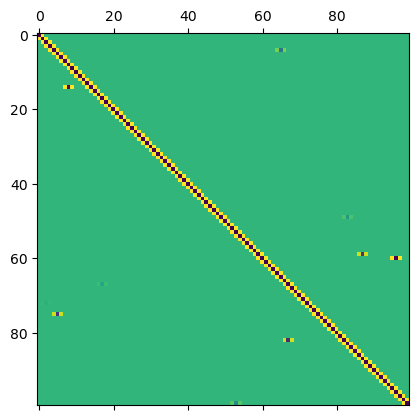

In [46]:
_ = plt.matshow(generate_random_helmholtz(100).toarray())

In [47]:
print(f'{get_sparsity(generate_random_helmholtz(500).toarray())*100:.3f}%') 

0.897%


In [48]:
test_singularity(generate_random_helmholtz(500).toarray())

Matrix is non-singular.
Matrix is singular.


/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


False

## b Vectors

*Using the same as before.*

## Solvers

Testing solvers on this data.

### Conjugate Gradient (CG)

Solver good for SPD.

In [49]:
A = generate_random_helmholtz(500)
b = normal_b_vector(A.shape[0], scale=1)
cb = Callback()

x, exit_code = spla.cg(A, b, callback=cb.log, rtol=1e-12, maxiter=10000)

In [50]:
exit_code, cb.cb

(10000, 10000)

### Generalized Minimal RESidual (GMRES)

Solver good for non-symmetric, indefinite.

In [51]:
A = generate_random_helmholtz(750)
b = normal_b_vector(A.shape[0], scale=1)
cb = Callback()

x, exit_code = spla.gmres(A, b, callback_type='legacy', callback=cb.log, maxiter=10000, restart=30, rtol=1e-5)

In [52]:
exit_code, cb.cb

(10000, 10000)

## Preconditioning

This time tested on both GMRES and CG.

### Jacobi

M = diag(A) preconditioner.

In [53]:
A = generate_random_helmholtz(500).toarray()
b = normal_b_vector(A.shape[0], scale=1)
M = np.eye(A.shape[0]) * (1 / np.diag(A))
cb = Callback()

x, exit_code = spla.cg(A, b, callback=cb.log, rtol=1e-12, maxiter=10000)

In [54]:
exit_code, cb.cb

(10000, 10000)

In [55]:
test_inconsistent(A, b)

System may be consistent.
System is consistent or has infinitely many solutions.


In [56]:
A = generate_random_helmholtz(500).toarray()
b = normal_b_vector(A.shape[0], scale=1)
M = np.eye(A.shape[0]) * (1 / np.diag(A))
cb = Callback()

x, exit_code = spla.gmres(A, b, M=M, callback_type='legacy', callback=cb.log, maxiter=10000, restart=10, rtol=1e-12)

In [57]:
exit_code, cb.cb

(10000, 10000)

In [58]:
test_inconsistent(A, b)

System may be consistent.
System is consistent or has infinitely many solutions.


(24570.915042668214, 24570.915042718756)

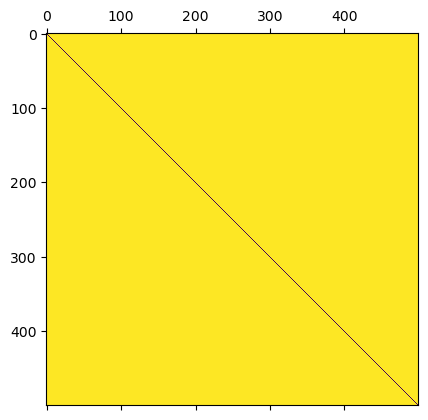

In [59]:
_ = plt.matshow(M)
np.linalg.cond(M @ A), np.linalg.cond(A)

### Incomplete LU (ILU)

Approximates the LU decomposition.

In [60]:
A = generate_random_helmholtz(500).toarray()
b = normal_b_vector(A.shape[0], scale=1)

ilu = spla.spilu(A)
Mx = lambda x: ilu.solve(x)
M = spla.LinearOperator(A.shape, Mx)

cb = Callback()

x, exit_code = spla.cg(A, b, callback=cb.log, rtol=1e-12, maxiter=10000)

/tmp/ipykernel_2947540/1656611989.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A)


In [61]:
exit_code, cb.cb

(10000, 10000)

In [62]:
test_inconsistent(A, b)

System may be consistent.
System is consistent or has infinitely many solutions.


In [ ]:
A = generate_random_helmholtz(500).toarray()
b = normal_b_vector(A.shape[0], scale=1)

ilu = spla.spilu(A, fill_factor=0)
Mx = lambda x: ilu.solve(x)
M = spla.LinearOperator(A.shape, Mx)

cb = Callback()

x, exit_code = spla.gmres(A, b, M=M, callback_type='legacy', callback=cb.log, maxiter=10000, restart=20)

/tmp/ipykernel_2947540/894944570.py:4: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A, fill_factor=0)


In [ ]:
exit_code, cb.cb

In [ ]:
test_singularity(M @ A)

In [ ]:
(M.dot(np.eye(500)) != 0).sum() / (M.shape[0] * M.shape[1])

In [ ]:
plt.matshow(M.dot(np.eye(500)))
np.linalg.cond(M.dot(np.eye(500))), np.linalg.cond(A)

### AMG

Good for large sparse systems.

In [65]:
A = generate_random_helmholtz(500).toarray()
b = normal_b_vector(A.shape[0], scale=1)

# Create the AMG preconditioner
ml = pyamg.smoothed_aggregation_solver(A)
M = ml.aspreconditioner()

cb = Callback()

x, exit_code = spla.gmres(M @ A, M @ b, callback_type='legacy', callback=cb.log, maxiter=10000, restart=20)

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


In [66]:
exit_code, cb.cb

(10000, 10000)

In [67]:
test_inconsistent(A, b)

System may be consistent.
System is consistent or has infinitely many solutions.


(13324.186517997965, 4290.207745751002)

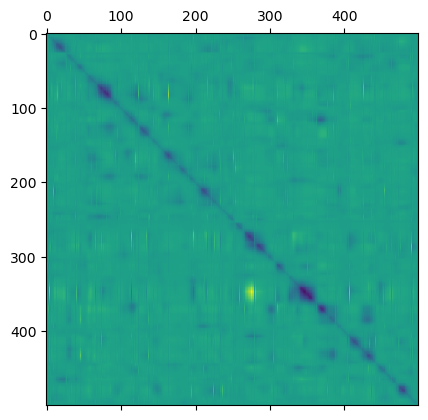

In [68]:
plt.matshow(M.dot(np.eye(500)))
np.linalg.cond(M @ A), np.linalg.cond(A)

## Solver Statistics

Understand more about the significant of A and b.

In [106]:
def get_precond(A, precon):
    if precon == 'ILU':
        ilu = spla.spilu(A)
        Mx = lambda x: ilu.solve(x)
        return spla.LinearOperator(A.shape, Mx)
        
    elif precon == 'AMG':
        ml = pyamg.smoothed_aggregation_solver(A)
        return ml.aspreconditioner()

*Testing singularities given sizes and densities.*

In [217]:
test_singularity(generate_random_helmholtz(500, density=0.001).toarray())

Matrix is non-singular.
Matrix is non-singular.


True

Max cutoff is 1,000,000 iterations.

In [218]:
def generate_gmres_stats(n, iterations, precon=None):
    logs_iter = np.zeros(iterations)
    logs_exit = np.zeros(iterations)
    logs_condition = np.zeros(iterations)
    for iteration in range(iterations):
        while True:
            A = generate_random_helmholtz(n).toarray()
            if test_singularity(A):
                print('No Singular Encountered.')
                break
            
        b = normal_b_vector(A.shape[0], scale=1)
        cb = Callback()
        
        if precon is not None:
            M = get_precond(A, precon)
            x, exit_code = spla.gmres(M @ A, M @ b, callback_type='legacy', callback=cb.log, maxiter=1000000, restart=30, rtol=1e-5)
            logs_condition[iteration] = np.linalg.cond(M @ A)
        else:
            x, exit_code = spla.gmres(A, b, callback_type='legacy', callback=cb.log, maxiter=1000000, restart=30, rtol=1e-5)
            logs_condition[iteration] = np.linalg.cond(A)
        
        logs_iter[iteration] = cb.cb
        logs_exit[iteration] = 0 if exit_code == 0 else 1
        
    return logs_iter, logs_exit, logs_condition

In [219]:
solver_stats = {}
iterations = 15

In [220]:
for pre in [None, 'ILU', 'AMG']:
    for it in [500, 750, 1000]:
        solver_stats[f'{pre}_{it}'] = generate_gmres_stats(it, iterations, precon=pre)
        print(f'Done: {pre}, {it}')

Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No 

/tmp/ipykernel_4164370/1766281076.py:3: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A)


Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No 

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No Singular Encountered.
Matrix is non-singular.
Matrix is non-singular.
No 

In [222]:
iterations_logs = []
exit_logs = []
condition_logs = []

for it in [500, 750, 1000]:
    iters, exits, condition = solver_stats[f'{None}_{it}']
    
    iterations_logs.append(np.mean(iters))
    exit_logs.append(np.sum(exits))
    condition_logs.append(np.mean(condition))

In [1]:
solver_stats

NameError: name 'solver_stats' is not defined

<AxesSubplot: >

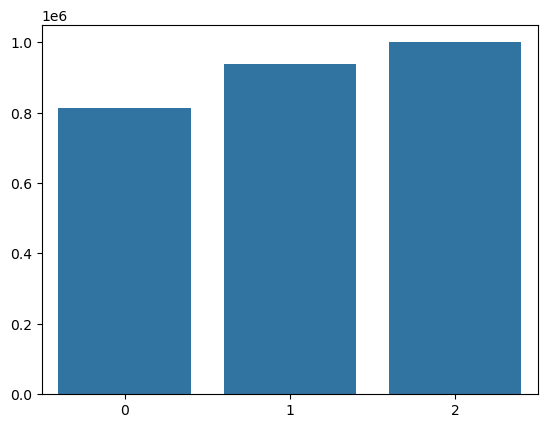

In [226]:
sns.barplot(iterations_logs)

<AxesSubplot: >

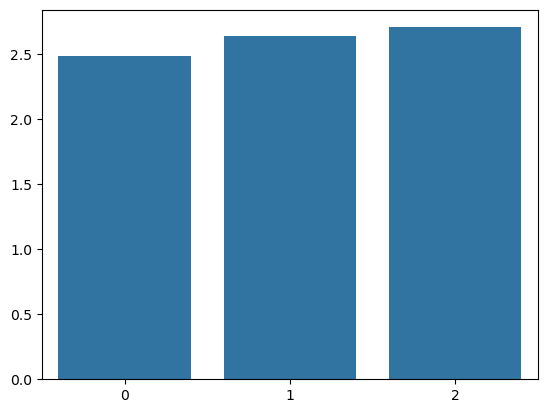

In [224]:
sns.barplot(np.log(exit_logs))

<AxesSubplot: >

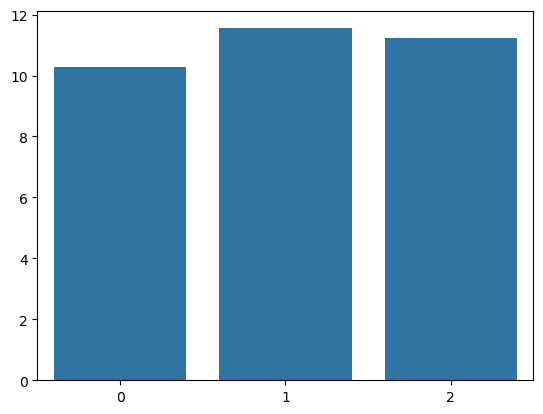

In [225]:
sns.barplot(np.log(condition_logs))